apm 67.243.14.146_gk_model11 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            6
   Intermediates:            0
   Connections  :            1
   Equations    :            5
   Residuals    :            5
 
 Number of state variables:            702
 Number of total equations: -          650
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             52
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipo

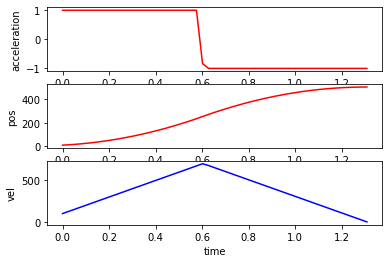

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

# This optimizer will minimize time to get to desired end points

# Next I will need to add to the cost function the error between the rocket and the desired set point

class Optimizer():
    def __init__(self):
        self.d = GEKKO(remote=True) # Driving on ground optimizer

        ntd = 51 # Number of time discretizations

        self.d.time = np.linspace(0, 1, ntd) # Time vector normalized 0-1

        # options
        self.d.options.NODES = 3
        self.d.options.SOLVER = 3
        self.d.options.IMODE = 6# MPC mode
        self.d.options.MAX_ITER = 800
        self.d.options.MV_TYPE = 0
        self.d.options.DIAGLEVEL = 0

        # final time for driving optimizer
        self.tf = self.d.FV(value=1.0,lb=1,ub=100.0, name='tf')

        # allow gekko to change the tf value
        self.tf.STATUS = 1

        # Acceleration variable manipulatable
        self.a = self.d.MV(fixed_initial=False, lb = -1, ub = 1, name='a')
        self.a.STATUS = 1

        # Picker vector to pick out states for objective function
        # This one picks the last state by setting the vector to all 0's except the last element
        self.p_d = np.zeros(ntd)
        self.p_d[-1] = 1.0
        self.final = self.d.Param(value = self.p_d, name='final')
        
        # Magnitude of acceleration
        self.thr_mag = self.d.Param(value = 996, name='thr_mag')

    def optimize1D(self, s, v, sf, vf): #these are 1x2 vectors s or v [x, z]

        # variables intial conditions are placed here
        self.s = self.d.Var(value=s, lb=-4096, ub=4096, name='pos') #x position
        self.v = self.d.Var(value=v, lb=-5120, ub=5120, name='vel') #y position



# Differental equations
        self.d.Equation(self.v.dt()/self.tf == (self.a * self.thr_mag))

        self.d.Equation(self.s.dt()/self.tf == self.v)

# Cost functions (minimizing)
        # Minimze final desired state with state variables
        self.d.Obj(self.final*1e4*((self.s-sf)**2)) # Soft constraints
        self.d.Obj(self.final*1e4*((self.v-vf)**2))

        #Objective function to minimize time
        self.d.Obj(1e1*self.tf)

        #solve
        # self.d.solve('http://127.0.0.1') # Solve with local apmonitor server
        self.d.open_folder()
        self.d.solve(disp=True)

        self.ts = np.multiply(self.d.time, self.tf.value[0])

        return self.ts

    def getTrajectoryData(self):
        return [self.ts, self.sx, self.sy, self.vx, self.vy, self.yaw, self.omega]

    def getInputData(self):
        return [self.ts, self.a]

# Main Code

opt = Optimizer()

s = 10
v = 100
sf = 500
vf = 0
opt.optimize1D(s, v, sf, vf)

ts = opt.d.time * opt.tf.value[0]

# plot results
plt.figure(1)
plt.subplot(3,1,1)
plt.plot(ts, opt.a, 'r-')
plt.ylabel('acceleration')

plt.subplot(3,1,2)
plt.plot(ts, opt.s, 'r-')
plt.ylabel('pos')

plt.subplot(3, 1, 3)
plt.plot(ts, opt.v, 'b-')
plt.ylabel('vel')
plt.xlabel('time')

plt.show()


SyntaxError: invalid syntax (<ipython-input-23-158f2f8c772a>, line 1)